In [1]:
import os
import sys
import json
import random
import logging
import tarfile
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# from utils import fingerprints

import rdkit
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles, MolToSmiles
# from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcNumAtoms, CalcNumHeavyAtoms

import atomInSmiles
from utils.utils import configure_logger
from utils.fingerprints import MACCS, ECFP4, Avalon, RDK4_default, ECFP2, HashAP

configure_logger(level=logging.INFO)
logger = logging.getLogger(__name__)

2023-04-13 16:12:54.172780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 16:12:54.263228: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 16:12:54.263243: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Skipped loading some Tensorflow models, missing a dependency. No module named 'google.protobuf'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pyto

In [2]:
random_smi = 'data/chembl-random'
results_gz = 'data/chembl_results.tar.gz'
results_file = 'data/chembl_results.json'

FP_NAMES = {
    'ECFP2': ECFP2, 
    'ECFP4': ECFP4, 
    'RDKit': RDK4_default,
    'HashAP': HashAP, 
    'Avalon': Avalon, 
    'MACCS': MACCS
}

## Molecular Simiarity Calculations

2000 O=C(Cc1ccccc1)Nc1cc(C2CC2)[nH]n1


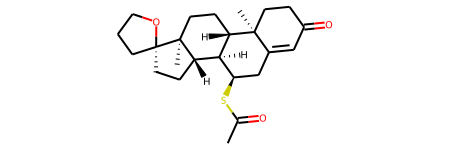

In [3]:
mol_list = []

for line in open(random_smi):
    dx, smiles, inchi, inchikey = line.strip().split('\t')
    mol = MolFromSmiles(smiles)
    mol_list.append(mol)
    
print(len(mol_list), smiles)
mol_list[0]

In [4]:

if not os.path.exists(results_gz):
    print(f"Results file doesn't exist: {results_file}")
    print(f"Calculating Pair-wise Tanimoto similarity...")
    results = {}
    for fpname, fp in FP_NAMES.items() :
        # fp = getattr(fingerprints, fpname)
        results[fpname] = list()
        logger.info(f'*** {fpname} starts...')
        for a, b in combinations(mol_list, 2):
            fp1 = fp(a)
            fp2 = fp(b)

            tc = DataStructs.TanimotoSimilarity(fp1, fp2)
            results[fpname].append(tc)
        logger.info(f'*** {fpname} completed ***')

    results['AIS'] = list()
    ais_list = []
    for mol in mol_list:
        smi = MolToSmiles(mol)
        ais = atomInSmiles.encode(smi, False)
        ais_list.append(ais)

    logger.info('*** AIS starts...')
    for a,b in combinations(ais_list, 2):
        tc = atomInSmiles.similarity(a, b)
        results['AIS'].append(tc)
    logger.info('*** AIS completed ***')

    logger.info(f'Saving the results: {results_file}')
    json.dump(results, open(results_file, 'w'))
else:
    with tarfile.open(results_gz) as tarf:
        tarf.extractall('data')
    logger.info(f"Results file exits, loading from: {results_file}")
    results = json.load(open(results_file))

2023-04-13 16:12:56 - __main__ - INFO - Results file exits, loading from: data/chembl_results.json


## Plot figure

ECFP4 0.147251187592825 0.0592401585319465
HashAP 0.18832726579122736 0.08707638346410687
ECFP2 0.20776647513502253 0.08572291432036079
RDKit 0.28121434393729344 0.10018965080042955
Avalon 0.3390972328658387 0.1113962795189091
MACCS 0.38800492170472906 0.12097154736650809


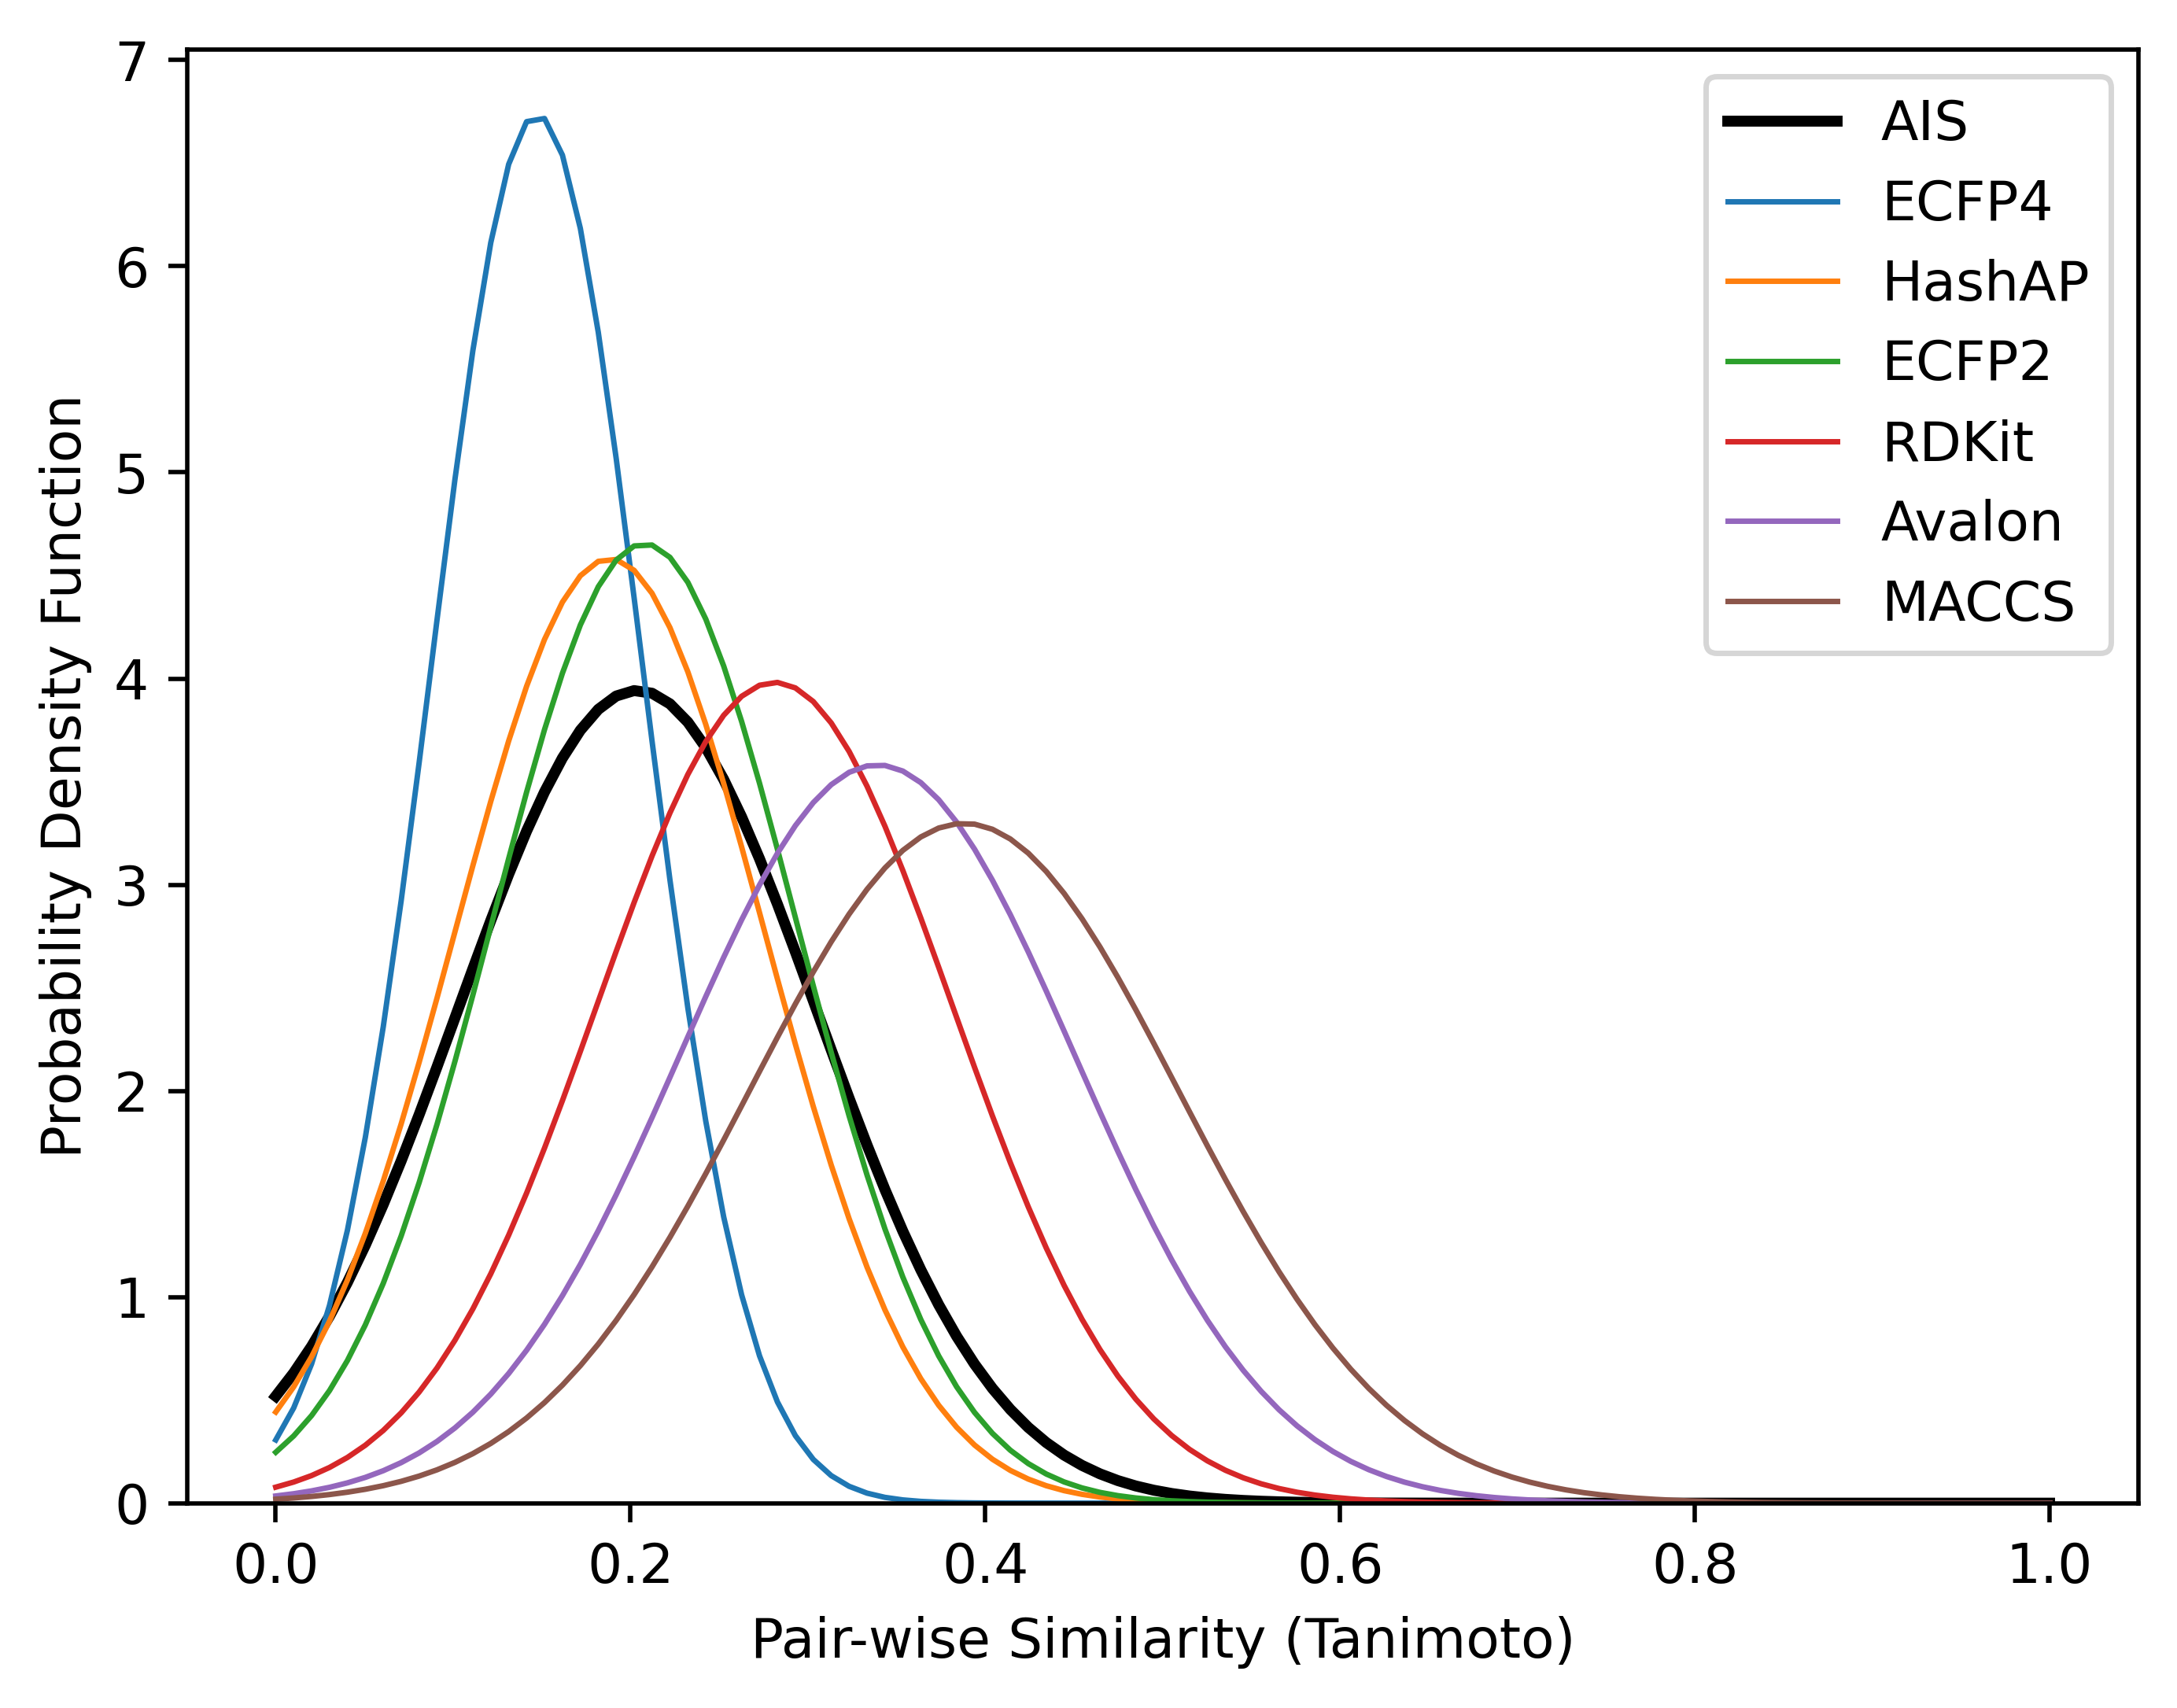

In [5]:

fpname = 'AIS'
mu, std = norm.fit(results[fpname])

# Plot the histogram.
fig = plt.figure(dpi=500)
plt.hist(results[fpname], bins=150, density=True, alpha=0.0, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(0, 1, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, linewidth=2, color='black', label=fpname)


for fpname in ['ECFP4', 'HashAP', 'ECFP2', 'RDKit', 'Avalon', 'MACCS']:
    mu, std = norm.fit(results[fpname])
    print(fpname, mu, std)
    
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=1, label=fpname)

plt.legend()
plt.xlabel('Pair-wise Similarity (Tanimoto)')
plt.ylabel('Probability Density Function')
fig.patch.set_facecolor('white')
fig.savefig('AIS-as-fingerprint.png')